# Materials preprocessing & featurization basic



## **Step 0 : Data retrieval and filtering**

In [ ]:
# Install libraries to use matminer.
!pip install --upgrade matplotlib==3.8.0
!pip install --upgrade pyyaml six matminer[citrine] citrination-client pymatgen

# This will restart the environment, allowing you to re-run the code with the correct versions.
#import os
#os.kill(os.getpid(), 9)

# Ignore the warning message
import warnings
warnings.filterwarnings('ignore')

# Load the required libraries
import numpy as np # a software library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
import pandas as pd # a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series
import matplotlib.pyplot as plt # a plotting library for the Python programming language
import seaborn as sns # Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics

# sklearn is a machine learning software library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting,
# k-means and DBSCAN, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
# All datasets can be loaded using the load_dataset() function and the database name.
from matminer.datasets import load_dataset

df = load_dataset("dielectric_constant")

In [ ]:
# We can get some more detailed information about this dataset using the get_all_dataset_info(<dataset>) function from matminer.
from matminer.datasets import get_all_dataset_info

print(get_all_dataset_info("dielectric_constant"))

## **Step 1: Data preprocessing**

### Inspecting the dataset

In [ ]:
# The head() function prints a summary of the first few rows of a data set.
print(df.head())

In [ ]:
# You can see the full list of columns using the columns attribute
print(df.columns)

In [ ]:
#  A pandas DataFrame includes a function called describe() that helps determine statistics for the various numerical/categorical columns in the data.
print(df.describe())

### Filtering the dataset

In [ ]:
# We can use the typical Python comparison operators (==, >, >=, <, etc) to filter numerical values.
# For example, let's find all entries where the cell volume is greater than 580.
mask = df["volume"] >= 580
df[mask]

In [ ]:
# If we want to get the materials with a non-zero band gap,
#  we can do this easily by filtering the band_gap column.
mask = df["band_gap"] > 0
nonmetal_df = df[mask]
nonmetal_df

In [ ]:
# Often, a dataset contains many additional columns that are not necessary for machine learning.
# Before we can train a model on the data, we need to remove any extraneous columns.
# We can remove whole columns from the dataset using the drop() function.
# For example, to remove the nsites, space_group, e_electronic, and e_total columns
cleaned_df = df.drop(["nsites", "space_group", "e_electronic", "e_total"], axis=1)
cleaned_df.head()
# The axis option specifies whether the data to drop is columns (1) or rows (0).

In [ ]:
# You can alternatively select multiple columns by passing in a list of column names as an index.
# For example, if we're only interested in the band_gap and structure columns, we can index with ["band_gap", "structure"]
df[["band_gap", "structure"]]

### Generating new columns

In [ ]:
# Pandas DataFrame objects also make it easy to perform simple calculations on the data.
# For example, the dielectric dataset contains the electronic contribution to the dielectric constant and total dielectric constant.
# We  can calculate the ionic contribution to the dielectric constant and store it in a new column called poly_ionic.
df["poly_ionic"] = df["poly_total"] - df["poly_electronic"]
df.head()

## **Step 2 : Generating features for machine learning**


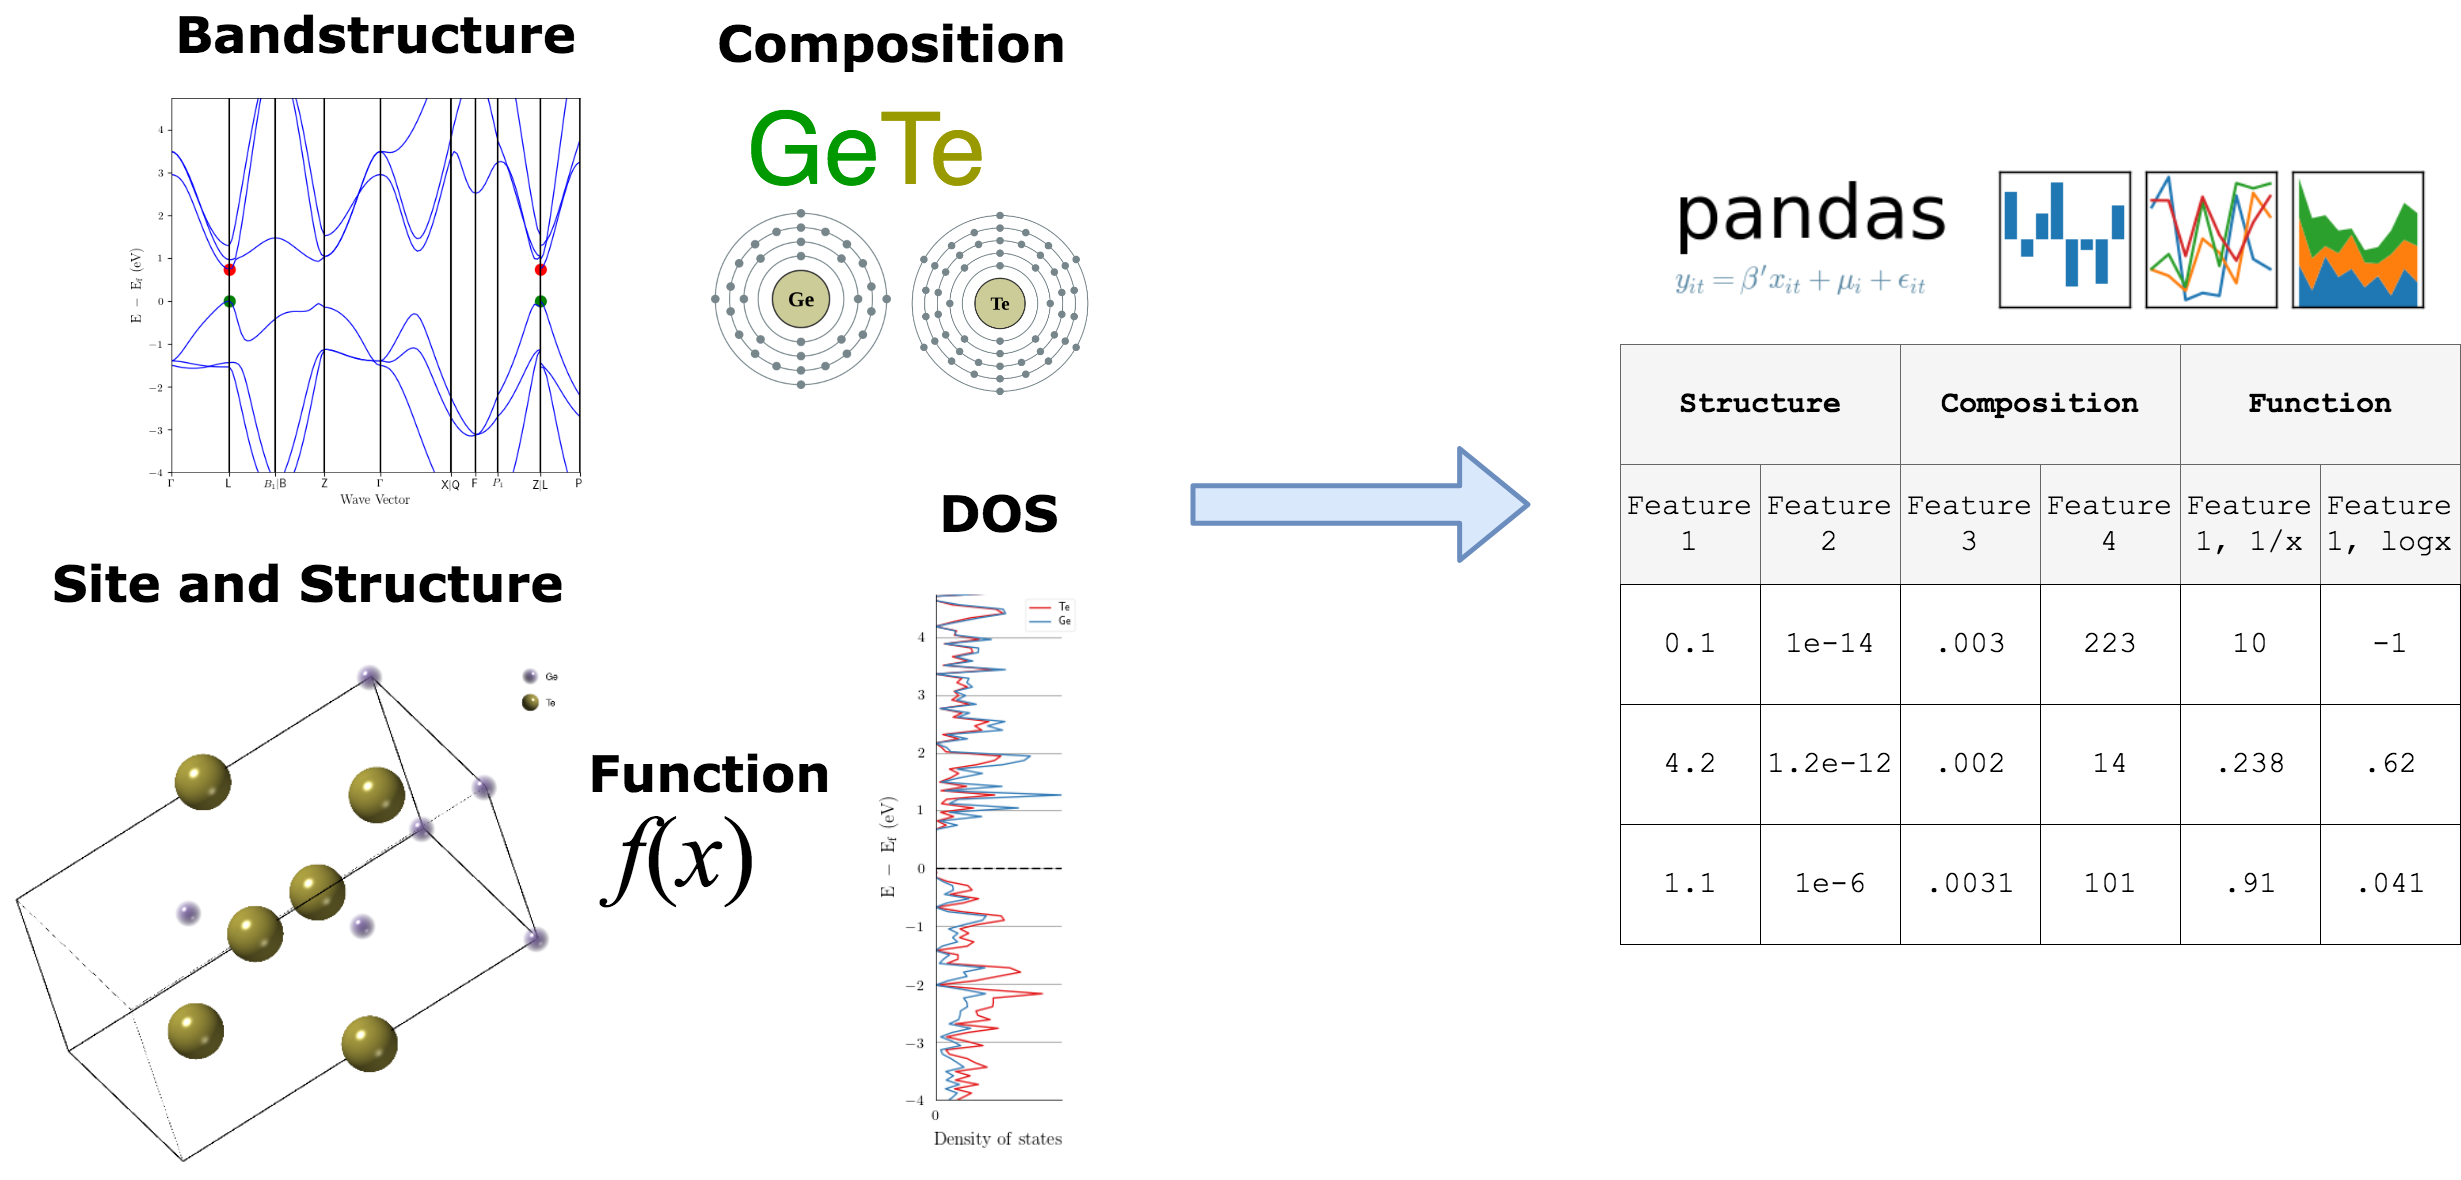

We will learn a bit about how to generate machine-learning features (descriptors) from materials objects in pymatgen. First, we'll generate some descriptors with matminer's "featurizers" classes. Next, we'll use some of what we learned about dataframes in the previous section to examine our descriptors and prepare them for input to machine learning models.

The general idea of featurizers is that they accept a materials primitive (e.g., pymatgen Composition) and output a vector. For example: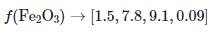

Matminer contains featurizers for the following pymatgen objects:

*   Composition
*   Crystal structure
*   Crystal sites
*   Bandstructure
*   Density of states

Depending on the featurizer, the features returned may be:
numerical, categorical, or mixed vectors

*   numerical, categorical, or mixed vectors
*   matrices
*   other pymatgen objects (for further processing)

### **The featurize method and basics**

In [ ]:
# The core method of any matminer is "featurize".
# This method accepts a materials object and returns a machine learning vector or matrix.
from pymatgen.core import Composition
fe2o3 = Composition("Fe2O3")
fe2o3

In [ ]:
# We'll get the element fractions with the ElementFraction featurizer.
from matminer.featurizers.composition.element import ElementFraction
ef = ElementFraction()
# We can featurize our composition.
element_fractions = ef.featurize(fe2o3)
print(element_fractions)

In [ ]:
?ef

In [ ]:
# Through the feature_labels() method, you can know the meaning of the featurized data.
element_fraction_labels = ef.feature_labels()
print(element_fraction_labels)

In [ ]:
print(element_fraction_labels[7], element_fractions[7])
print(element_fraction_labels[25], element_fractions[25])

### **Featurizing dataframes**

We just generated some descriptors and their labels from an individual sample but most of the time our data is in pandas dataframes. Fortunately, matminer featurizers implement a featurize_dataframe() method which interacts natively with dataframes.

In [ ]:
# Download dataset
from matminer.datasets.dataset_retrieval import load_dataset

df = load_dataset("brgoch_superhard_training")
df.head()

In [ ]:
from matminer.datasets.dataset_retrieval import load_dataset

df = load_dataset("brgoch_superhard_training")
df.head()

In [ ]:
# We can use the featurize_dataframe() method (implemented by all featurizers) to apply ElementFraction to all of our data at once.
df = ef.featurize_dataframe(df, "composition")

df.head()

### **Structure Featurizers**

We can use the same syntax for other kinds of featurizers. Let's now assign descriptors to a structure. We do this with the same syntax as the composition featurizers.

In [ ]:
# Download dataset containing structures.
df = load_dataset("phonon_dielectric_mp")
df.head()

In [ ]:
# Let's calculate some basic density features of these structures using DensityFeatures.
from matminer.featurizers.structure import DensityFeatures

densityf = DensityFeatures()
densityf.feature_labels() # These are the features we will get.

In [ ]:
# Now we use featurize_dataframe() to generate these features for all the samples in the dataframe.
# Since we are using the structures as input to the featurizer, we select the "structure" column.
df = densityf.featurize_dataframe(df, "structure")

df.head()

### **Conversion Featurizers**


In addition to Bandstructure/DOS/Structure/Composition featurizers, matminer also provides a featurizer interface for converting between pymatgen objects (e.g., assigning oxidation states to compositions) in a fault-tolerant fashion.

In [ ]:
#  To convert this data into a composition column containing pymatgen Composition objects, we can use the StrToComposition conversion featurizer on the formula column.
from matminer.featurizers.conversions import StrToComposition

stc = StrToComposition()
df = stc.featurize_dataframe(df, "formula", pbar=False)
df.head()

# Example : Predicting bulk modulus

We deal with the data processing process to predict the bulk modulus.

In [ ]:
from matminer.datasets.convenience_loaders import load_elastic_tensor
df = load_elastic_tensor()  # loads dataset in a pandas DataFrame object
df.columns # check columns

In [ ]:
# Removing unneeded columns from the data set
# Not all data is required for modeling.
unwanted_columns = ["volume", "nsites", "compliance_tensor", "elastic_tensor",
                    "elastic_tensor_original", "K_Voigt", "G_Voigt", "K_Reuss", "G_Reuss"]
df1 = df.drop(unwanted_columns, axis=1)

In [ ]:
# Add composition-based features
# A major class of featurizers available in matminer uses the chemical composition to featurize the input data.
# Let's add some composition based features to our DataFrame.

# First step : Using the conversions Featurizers in matminer to turn a String composition (our formula column from before) into a pymatgen Composition.
from matminer.featurizers.conversions import StrToComposition
df2 = StrToComposition().featurize_dataframe(df1, "formula")
df2.head() # It will be possible to confirm that a new composition column is formed.

In [ ]:
comp = df2.loc[0, "composition"]

In [ ]:
comp.as_dict()

In [ ]:
# Second step : Using one of the featurizers in matminer to add a suite of descriptors to the DataFrame.
# https://hackingmaterials.lbl.gov/matminer/matminer.featurizers.composition.html#matminer.featurizers.composition.composite.ElementProperty

from matminer.featurizers.composition import ElementProperty

# We can use presets provided by matminer. For example, we use feature set "magpie" defined by Wolverton's group.
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df3 = ep_feat.featurize_dataframe(df2, col_id="composition")  # input the "composition" column to the featurizer
df3.head() # It can be seen that many composition-related features are newly created in the data.

In [ ]:
# Add more composition-based features
# There are many more Composition based featurizers apart from ElementProperty that are available in the matminer.featurizers.composition.
# Let's try the ElectronegativityDiff featurizer which requires knowing the oxidation state of the various elements in the Composition.

from matminer.featurizers.conversions import CompositionToOxidComposition
df4 = CompositionToOxidComposition().featurize_dataframe(df3, "composition") # compositon -> composition_oxid // add oxidation states
df4.head(5)

In [ ]:
# Add statistical features of oxidation states
from matminer.featurizers.composition import OxidationStates
os_feat = OxidationStates()
df5 = os_feat.featurize_dataframe(df4, "composition_oxid")
df5.head()

In [ ]:
# Add some structure based features
from matminer.featurizers.structure import DensityFeatures
df_feat = DensityFeatures()
df6 = df_feat.featurize_dataframe(df5, "structure")  # input the structure column to the featurizer
df6.head()

### **Recognize features that correlate with bulk modulus**

In [ ]:
# Select only the numeric columns for correlation
numeric_df = df6.select_dtypes(include=[np.number])
# Remove columns with a single unique value (which don't contribute to correlation)
numeric_df = numeric_df.loc[:, numeric_df.apply(lambda col: col.nunique() != 1)]

# Now plot the heatmap for the correlation matrix of numeric columns
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
plt.show()

In [ ]:
def identify_columns(x_new, nrows=10):
    columns = x_data.columns
    xvalues = x_data.values
    dist = np.linalg.norm(xvalues[:nrows, :, None] - x_new[:nrows, None, :], axis=0)
    return columns[np.argmin(dist, axis=0)].values

In [ ]:
# Our target property is Voigt-Reuss-Hill bulk modulus ('K_VRH')
x_data = numeric_df[numeric_df.columns.values]
y_data = numeric_df['K_VRH']

In [ ]:
# Use SelectKBest to select top 10 features
sel = SelectKBest(f_regression, k=10)
x_new = sel.fit_transform(x_data, y_data)

# Get the mask of selected features
mask = sel.get_support()  # Boolean mask of selected features

# Extract the column names of the selected features
selected_columns = x_data.columns[mask]

# Print the selected features using identify_columns
print(f"Selected features: {selected_columns}")

In [ ]:
# Visualize the correlation using a bar plot

selected_features_df = x_data[selected_columns]
selected_features_df['K_VRH'] = y_data
correlation_matrix = selected_features_df.corr()
target_correlation = correlation_matrix['K_VRH'].drop('K_VRH')

# Print the correlation values
print("Correlation of selected features with the target:")
print(target_correlation)

# Visualize the correlation using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=target_correlation.index, y=target_correlation.values, palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.title('Correlation of Selected Features with Target Property')
plt.show()